# setup

In [1]:
%%file locate_file.py

def locate_file() : 
    working_directory = ''
    for element in __file__.split('/')[:-1] : 
        working_directory += element + '/'
    return working_directory

Overwriting locate_file.py


In [2]:
import locate_file
import os
import matplotlib.pyplot as plt
import matplotlib
import numpy

working_directory = locate_file.locate_file()
os.chdir(working_directory)
%matplotlib inline

# convolution C function

In [3]:
%%file convolution.c
#include<stdio.h>

void convolution(int *image,int *kernel,int image_width, int image_height, int kernel_size, int kernel_normalizer) {
    
    int image_starting_x = 0;
    int image_starting_y = 0;
    int image_ending_x = image_width;
    int image_ending_y = image_height;
    
    int i,j,u,v;
    int sum;
    j=0;
    
    for(i=image_starting_y;i<image_height-kernel_size;i++) {
        for(j=image_starting_x;j<image_width-kernel_size;j++) {
            
            //current left top corner pixel is i,j
            sum = 0;
            for(u=0;u<kernel_size;u++) {
                for(v=0;v<kernel_size;v++) {
                    sum += (*(image + image_width*(i+u) + j+v))*(*(kernel + u*kernel_size + v));

                }
            }
            *(image + (image_width*i) + j) = sum/kernel_normalizer;
            
        }
    }
}

Overwriting convolution.c


# compiling

In [4]:
os.system('cd ' + working_directory)
!clang -c convolution.c
!clang -o convolution.so -shared convolution.o
!file convolution.so

convolution.so: Mach-O 64-bit dynamically linked shared library x86_64


# python wrapper script

In [5]:
%%file libconvolution.py
import ctypes
import locate_file
import numpy

working_directory = locate_file.locate_file()

_convolution_ = ctypes.cdll.LoadLibrary(working_directory + 'convolution.so')

class two_d_array() : 
    
    def from_param(self,param) : 
        typename = type(param).__name__
        if hasattr(self,'from_'+typename) : 
            return getattr(self,'from_'+typename)(param)
        elif isinstance(param,ctypes.Array) : 
            
            return param
        else : 
            raise TypeError('type %s not supported' %typename)
    
    def from_ndarray(self,param) : 
        c_array = numpy.ascontiguousarray(param,dtype=numpy.uint32)
        pointer = c_array.ctypes
        return pointer
    
    def from_list(self,param) : 
        return self.from_ndarray(param)
    
    def from_tuple(self,param) : 
        return self.from_ndarray(param)
    
two_d_array_ = two_d_array()

_convolution_.convolution.argtypes = [two_d_array_,two_d_array_,ctypes.c_int,ctypes.c_int,ctypes.c_int,ctypes.c_int]
_convolution_.convolution.restype = ctypes.c_void_p

def convolution(image,kernel,kernel_normalizer) : 
    '''
    ADD BORDER TO IMAGE
    '''
    image_c_array = numpy.ascontiguousarray(image,dtype=numpy.uint32)
    kernel_c_array = numpy.ascontiguousarray(kernel,dtype=numpy.uint32)
    _convolution_.convolution(image_c_array,kernel_c_array,len(image[0]),len(image),len(kernel),kernel_normalizer)
    '''
    REMOVE BORDER FROM IMAGE
    '''
    return numpy.ascontiguousarray(image_c_array,dtype=numpy.uint8)

Overwriting libconvolution.py


In [6]:
%%file image_processing.py
import numpy

class image_processing() : 
    
    def __init__(self) : 
        pass
    
    def convolution(self,image,kernel) : 
        
        scaling_factor = kernel[0]
        kernel = kernel[1]
        image_width = len(image[0])
        image_height = len(image)
        kernel_width = len(kernel[0])
        kernel_height = len(kernel)

        return_image = []

        def element_wise_matrix_multiplication(matrix1,matrix2,scaling_factor=1) :
            return_value = 0
            for m1_row,m2_row in zip(matrix1,matrix2) :
                for m1_pixel,m2_pixel in zip(m1_row,m2_row) :
                    return_value += int(m1_pixel)*int(m2_pixel)
            return numpy.uint8(return_value/scaling_factor)
                
        for row in range(image_height - kernel_height + 1) :
            return_image.append([])
            for pixel in range(image_width - kernel_width + 1) :
                image_slice = [[image[i,j] for j in range(pixel,pixel + kernel_width)]\
                               for i in range(row,row + kernel_height)]
                #print(image_slice)
                return_image[-1].append(element_wise_matrix_multiplication(image_slice,kernel,scaling_factor))
        return numpy.array(return_image)
    
    def rgb_to_grayscale(self,image) : 
        return_image = []
        for row in image : 
            return_image.append([])
            for pixel in row : 
                try : 
                    [r,g,b,s] = pixel
                except ValueError : 
                    [r,g,b] = pixel
                return_image[-1].append(numpy.uint8((int(r)+int(g)+int(b))/3))
        return numpy.array(return_image)
    
    def add_images(self,image1,image2) :
        return_array = []
        for row1,row2 in zip(image1,image2) : 
            return_array.append([])
            for pixel1,pixel2 in zip(row1,row2) :
                return_array[-1].append(numpy.uint8((int(pixel1))|(int(pixel2))))
        return numpy.array(return_array)

Overwriting image_processing.py


# decorator to time functions execution time

In [7]:
def time_this_function(function) : 
    try : 
        time
    except : 
        import time
    
    def wrapper_function(*args,**kwargs) : 
        start_time = time.time()
        return_value = function(*args,**kwargs)
        elapsed_time = (time.time() - start_time)*1000
        print(function.__name__ + ' -- elapsed_time -- ' + str(elapsed_time),end=' ms\n')
        return return_value
    return wrapper_function

# time to compare

In [8]:
import libconvolution
import image_processing
import numpy
impr = image_processing.image_processing()

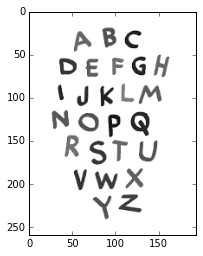

In [9]:
image = plt.imread('sample_image_3.png')

#converting image to (255 to 0) scale rather that (1.0 to 0.0) scale
def convert_to_harmless_image(image) : 
    new_image = []
    for row in image :
        new_image.append([])
        for pixel in row : 
            new_image[-1].append(numpy.uint8(pixel*255))
    return new_image
            
image = impr.rgb_to_grayscale(convert_to_harmless_image(image))

plt.imshow(image,cmap=matplotlib.pyplot.get_cmap('gray'))

kernel = [273,[[1,4 ,7 ,4 ,1],
                   [4,16,26,16,4],
                   [7,26,41,26,7],
                   [4,16,26,16,4],
                   [1,4 ,7 ,4 ,1]]]

# kernel = [9,[[1,1,1],[1,1,1],[1,1,1]]]

kernel_normalizer = kernel[0]

In [19]:
@time_this_function
def c_test() : 
    c_image = libconvolution.convolution(image,kernel[1],kernel[0])
    return c_image
    
@time_this_function
def python_test() : 
    python_image = impr.convolution(image,kernel)
    return python_image

c_image = c_test()
python_image = python_test()

c_test -- elapsed_time -- 5.134105682373047 ms
python_test -- elapsed_time -- 1150.5131721496582 ms


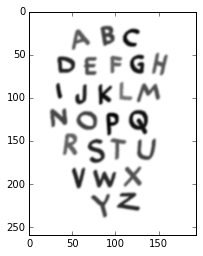

In [20]:
plt.imshow(c_image,cmap=matplotlib.pyplot.get_cmap('gray'))
# plt.imshow(python_image,cmap=matplotlib.pyplot.get_cmap('gray'))